# Customer Lifetime Value Prediction(Müşteri Yaşam Boyu Değeri Tahmini)

- Zaman projeksiyonlu olasılıksal lifetime value tahmini.

- Customer Value = Purchase frequency(satın alma sayısı) * Average Order Value(satın alma başına ortalama kazanç)

- CLTV = (Customer Value / Churn Rate) * Profit Margin

- CLTV = Conditional Expected Number of Transaction * Conditional Expected Average Profit

- Bütün kitlenin satın alma davranışlarını olasılık modeli ile modelleyeceğiz, daha sonra da bu olasılık modeli ile modellediğimiz davranış biçimlerini koşullu(yani kişi özelinde) biçimlendirecek şekilde kullanarak her bir kişi için beklenen satın alma(işlem) sayılarını tahmin edeceğiz.

- Kişi özelinde koşullayarak ana kitlenin dağılımından beslenmiş bir şekilde her bir kişi için average profitleri ve number of transaction'ları hesaplayacağız.

- CLTV = BG/NBD Model * Gamma Gamma Submodel

### BG/NBD(Beta Geometric/Negative Binomial Distribution) ile Expected Number of Transaction

- "Expected" bir rastsal değişkenin beklenen değerini ifade etmek için kullanılır. "Bir rastsal değişkenin beklenen değeri" de o rastsal değişkenin ortalaması demektir.

- Değerlerini bir deneyin sonuçlarından alan değişkene de "rastsal değişken" denir.

- Bir değişkenin belirli bir olasılık dağılımı izlediğini varsaydığımızda bu değişkenin ortalaması "Expected"  değerdir. Yani kitleden öğrenilen dağılım yapısına göre bu beklenen değer koşullandırılır(yani kişiler özelinde biçimlendiririz) ve her bir birey için beklenen işlem sayısı tahmin edilir.

- BG/NBD zaten tek başına satış tahmin modeli olarak kullanılan bir modeldir.

- BG/NBD nam-ı diğer "Buy Till You Die"

- Satın alma süreci aslında iki basamaktan meydana gelir. Birincisi satın alma(Buy) ikincisi ise satın almayı bırakma(churn,inactive,dropout olma) süreçleridir.

- BG/NBD modeli Expected Number of Transaction için iki süreci olasılıksal olarak modeller. Transaction Process(Buy)+Dropout Process(Till You Die)

#### Transaction Process(Buy)

- Alive(canlı) old.sürece,  belirli bir zaman periyodunda, bir müşteri tarafından  gerçekleştirilecek işlem sayısı transaction rate parametresi ile possion dağılır.

- Bir müşteri alive old. sürece kendi transaction rate'i etrafında rastgele satın alma yapmaya devam edecektir.

- Yani daha açık ve basit şekilde açıklarsak bir kullanıcı belirli bir satın alma davranışını kendi satın alma davranışı etrafında bekirli bir olasılıkla sürdürmeye devam eder.

- Transaction rate'ler her bir müşteriye göre değişir ve tüm kitle için gamma dağılır(r,a)(bir olasılık dağılımıdır)*** Important part

#### Dropout Process(Till You Die)

- Her bir müşterinin p olasılığı ile dropout rate(dropout probability)'i vardır.(churn, inactive olma olasılığı)

- Bir müşteri alışveriş yaptıktan sonra belirli bir olasılıkla drop olur.

- Dropout rate'ler her bir müşteriye göre değişir ve tüm kitle için beta dağılır(a,b). *** Important part

### Gamma Gamma Submodel

- Bir müşterinin işlem başına ortalama ne kadar kar getirebileceğini tahmin etmek için kullanılır.

- CLTV = Conditional Expected Number of Transaction * Conditional Expected Average Profit
- CLTV = BG/NBD Model * Gamma Gamma Submodel

- Average order value'nun olasılıksal hali diyebiliriz.

- Bir müşterinin işlemlerinin parasal değeri(monetary) transaction value'larının ortalaması etrafında rastgele dağılır.

- Ortalama transaction value, zaman içinde kullanıcılar arasında değişebilir fakat tek bir kullanıcı için değişmez.

- Ortalama transaction value tüm müşteriler arasında gamma dağılır. ***important

### 1. Data Preparation(Verinin Hazırlanması)

In [4]:
# Bir e-ticaret şirketi müşterilerini segmentlere ayırıp bu segmentlere göre pazarlama stratejileri belirlemek istiyor.

# Online Retail II isimli veri seti İngiltere merkezli online bir satış mağazasının
# 01/12/2009 - 09/12/2011 tarihleri arasındaki satışlarını içeriyor.


# Değişkenler

# InvoiceNo: Fatura numarası. Her işleme yani faturaya ait eşsiz numara. C ile başlıyorsa iptal edilen işlem.
# StockCode: Ürün kodu. Her bir ürün için eşsiz numara.
# Description: Ürün ismi
# Quantity: Ürün adedi. Faturalardaki ürünlerden kaçar tane satıldığını ifade etmektedir.
# InvoiceDate: Fatura tarihi ve zamanı.
# UnitPrice: Ürün fiyatı (Sterlin cinsinden)
# CustomerID: Eşsiz müşteri numarası
# Country: Ülke ismi. Müşterinin yaşadığı ülke.


##########################
# Gerekli Kütüphane ve Fonksiyonlar
##########################

# !pip install lifetimes
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)# sütunları aşağıya inmeden yan yana göstermek için bir düzenleme
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

In [5]:
#değişkenlerdeki aykırı değerleri tespit edip bu aykırı değerlere düzenleme getirilecek
# belirli bir eşik değerine göre aykırı değerler değiştirilecek, baskılanacak

# bu fonksiyon girilen değişkene göre eşik değerleri belirler 
# normalde quantile fonksiyonuna %25 ve %75 değerleri verilir ama bu veri seti için aralığı geniş tutmak daha iyi olacak
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)# burda 1. çeyrek değer belirlenir 
    quartile3 = dataframe[variable].quantile(0.99)# 2. çeyrek değer belirlenir
    interquantile_range = quartile3 - quartile1 # farkları alınır
    up_limit = quartile3 + 1.5 * interquantile_range #bu farkın 1.5 katı alınıp 2.çeyreğe eklenir ve üst limit bulunur
    low_limit = quartile1 - 1.5 * interquantile_range #bu farkın 1.5 katı 1.çeyrekten çıkarılır ve alt limit bulunur yani eşik değerleri
    return low_limit, up_limit


# dataframe ve variable değişkenleri ile bu fonksiyon çağrıldığında önce "outlier_thresholds(dataframe, variable)" ile eşik değerleri
# belirler daha sonra ilgili değişkendeki değerler arasında üst limiti aşanlar varsa bunların yerine "up_limit" değerini atar
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

### 2. Data Reading(Verinin Okunması)

In [6]:
df_ = pd.read_excel("C:\\Users\\Monster\\Desktop\\dataa\\online_retail_II.xlsx", sheet_name="Year 2010-2011")
df = df_.copy()

In [7]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,541910.0000,9.5522,-80995.0000,1.0000,3.0000,10.0000,80995.0000,218.0810
InvoiceDate,541910,2011-07-04 13:35:22.342307584,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 17:17:00,2011-10-19 11:27:00,2011-12-09 12:50:00,NaN
Price,541910.0000,4.6111,-11062.0600,1.2500,2.0800,4.1300,38970.0000,96.7598
Customer ID,406830.0000,15287.6842,12346.0000,13953.0000,15152.0000,16791.0000,18287.0000,1713.6031


In [8]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom


In [9]:
df.isnull().sum() # hangi değişkende kaçar tane eksik var

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [10]:
#########################
# Veri Ön İşleme
#########################

df.dropna(inplace=True) #eksik değerlerin hepsini siler
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]

In [11]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,397885.0000,12.9882,1.0000,2.0000,6.0000,12.0000,80995.0000,179.3316
InvoiceDate,397885,2011-07-10 23:41:56.419316992,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 14:39:00,2011-10-20 14:33:00,2011-12-09 12:50:00,NaN
Price,397885.0000,3.1165,0.0010,1.2500,1.9500,3.7500,8142.7500,22.0979
Customer ID,397885.0000,15294.4169,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000,1713.1444


In [12]:
# Quantity ve Price değişkenlerindeki aykırı değerler baskılanır
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

In [13]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,397885.0000,11.8308,1.0000,2.0000,6.0000,12.0000,298.5000,25.5231
InvoiceDate,397885,2011-07-10 23:41:56.419316992,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 14:39:00,2011-10-20 14:33:00,2011-12-09 12:50:00,NaN
Price,397885.0000,2.8935,0.0010,1.2500,1.9500,3.7500,37.0600,3.2272
Customer ID,397885.0000,15294.4169,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000,1713.1444


In [14]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [15]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0000,2010-12-01 08:26:00,2.5500,17850.0000,United Kingdom,15.3000
1,536365,71053,WHITE METAL LANTERN,6.0000,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0000,2010-12-01 08:26:00,2.7500,17850.0000,United Kingdom,22.0000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0000,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0000,2010-12-01 08:26:00,3.3900,17850.0000,United Kingdom,20.3400


In [16]:
# analiz tarihi olarak bu tarihi belirliyoruz, veri setindeki max tarihten 2 gün sonrası
today_date = dt.datetime(2011, 12, 11)

### 3. Preparation of Lifetime Data Structure(Lifetime Veri Yapısının Hazırlanması)

In [17]:
# recency: Son satın alma üzerinden geçen zaman. Haftalık. (kullanıcı özelinde) ancak bu normal receny değerinden biraz farklı
# analiz tarihine göre değil müşterinin kendi içinde son satın alması ile ilk satın alması arasındaki farktır burdaki yani bir kişi özelinde 
# T: Müşterinin yaşı. Haftalık. (analiz tarihinden ne kadar süre önce ilk satın alma yapılmış)
# frequency: tekrar eden toplam satın alma sayısı (frequency>1)
# monetary: satın alma başına ortalama kazanç, toplam kazanç değil yani ortalamasını alıyoruz


cltv_df = df.groupby('Customer ID').agg(
    {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                     lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
     'Invoice': lambda Invoice: Invoice.nunique(),
     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

# "lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days" ile recency hesaplandı gün cinsinden
# "lambda InvoiceDate: (today_date - InvoiceDate.min()).days" ile T değeri bu da gün cinsinden
# "lambda Invoice: Invoice.nunique()" frequency değeri(her bir müşterinin fatura sayısı)
# "lambda TotalPrice: TotalPrice.sum()" ise toplam monetary değerini hesaplar

In [18]:
cltv_df

InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.0000            0        326        1   310.4400
12347.0000          365        368        7  4310.0000
12348.0000          282        359        4  1770.7800
12349.0000            0         19        1  1491.7200
12350.0000            0        311        1   331.4600
...                 ...        ...      ...        ...
18280.0000            0        278        1   180.6000
18281.0000            0        181        1    80.8200
18282.0000          118        127        2   178.0500
18283.0000          333        338       16  2094.8800
18287.0000          158        202        3  1837.2800

[4338 rows x 4 columns]

In [19]:

cltv_df.columns = cltv_df.columns.droplevel(0)

In [20]:
cltv_df.head()

,<lambda_0>,<lambda_1>,<lambda>,<lambda>
Customer ID,,,,
12346.0000,0,326,1,310.4400
12347.0000,365,368,7,4310.0000
12348.0000,282,359,4,1770.7800
12349.0000,0,19,1,1491.7200
12350.0000,0,311,1,331.4600


In [21]:
# lambda0,1... yerine daha uygun isimlendirme yapalım
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']

In [22]:
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,0,326,1,310.4400
12347.0000,365,368,7,4310.0000
12348.0000,282,359,4,1770.7800
12349.0000,0,19,1,1491.7200
12350.0000,0,311,1,331.4600


In [23]:
# başta hesaplanan monetary değeri toplam değerdi, frequency değerine bölerek asıl monetary değerini elde ederiz
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

In [24]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4338.0000,130.4486,132.0396,0.0000,0.0000,92.5000,251.7500,373.0000
T,4338.0000,223.8310,117.8546,1.0000,113.0000,249.0000,327.0000,374.0000
frequency,4338.0000,4.2720,7.6980,1.0000,1.0000,2.0000,5.0000,209.0000
monetary,4338.0000,364.1185,367.2582,3.4500,176.8512,288.2255,422.0294,6207.6700


In [25]:
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

In [26]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,2845.0000,198.9054,113.8670,0.0000,98.0000,207.0000,299.0000,373.0000
T,2845.0000,258.7842,102.9909,3.0000,192.0000,283.0000,359.0000,374.0000
frequency,2845.0000,5.9891,9.0442,2.0000,2.0000,4.0000,6.0000,209.0000
monetary,2845.0000,372.1736,349.3012,3.4500,191.0733,300.4873,436.8700,5724.3026


In [27]:
# recency değeri haftalık cinsten olmalı bu nedenle 7'ye bölüyoruz
cltv_df["recency"] = cltv_df["recency"] / 7

In [28]:
cltv_df["T"] = cltv_df["T"] / 7

In [29]:
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12347.0000,52.1429,52.5714,7,615.7143
12348.0000,40.2857,51.2857,4,442.6950
12352.0000,37.1429,42.4286,8,219.5425
12356.0000,43.1429,46.5714,3,937.1433
12358.0000,21.2857,21.5714,2,575.2100


In [30]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,2845.0000,28.4151,16.2667,0.0000,14.0000,29.5714,42.7143,53.2857
T,2845.0000,36.9692,14.7130,0.4286,27.4286,40.4286,51.2857,53.4286
frequency,2845.0000,5.9891,9.0442,2.0000,2.0000,4.0000,6.0000,209.0000
monetary,2845.0000,372.1736,349.3012,3.4500,191.0733,300.4873,436.8700,5724.3026


#### 3.1. Establishment of BG-NBD Model(BG-NBD Modelinin Kurulması)

In [31]:
# en çok olabilirlik yöntemi ile Beta ve Gamma dağılımlarının parametrelerini bulmakta ve bir tahmin yapabilmek için ilgili modeli oluşturmaktadır
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.41, b: 2.49, r: 2.18>

In [32]:
################################################################
# 1 hafta içinde en çok satın alma beklediğimiz 10 müşteri kimdir?
################################################################

# purchases transaction'a karşılık gelir, aynısıdır
# "up_to_time" ile de belirli bir zaman periyodu old. ifade edilmiş, 1'de 1 haftalık tahmini ifade eder
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
12748.0000   3.2495
14911.0000   3.1264
17841.0000   1.9402
13089.0000   1.5374
14606.0000   1.4639
15311.0000   1.4336
12971.0000   1.3569
14646.0000   1.2064
13408.0000   0.9862
18102.0000   0.9685
dtype: float64

In [33]:
# yukarıdaki işlemin aynısını "predict" fonksiyonu ile de yapabiliriz
bgf.predict(1,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
12748.0000   3.2495
14911.0000   3.1264
17841.0000   1.9402
13089.0000   1.5374
14606.0000   1.4639
15311.0000   1.4336
12971.0000   1.3569
14646.0000   1.2064
13408.0000   0.9862
18102.0000   0.9685
dtype: float64

In [34]:
# tüm müşteriler için 1 haftalık beklenen satın almayı hesaplayıp dataframe'e ekleyelim
cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])

In [35]:
cltv_df

,recency,T,frequency,monetary,expected_purc_1_week
Customer ID,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1413
12348.0000,40.2857,51.2857,4,442.6950,0.0920
12352.0000,37.1429,42.4286,8,219.5425,0.1824
12356.0000,43.1429,46.5714,3,937.1433,0.0862
12358.0000,21.2857,21.5714,2,575.2100,0.1223
...,...,...,...,...,...
18272.0000,34.8571,35.2857,6,513.0967,0.1721
18273.0000,36.4286,36.8571,3,68.0000,0.1043
18282.0000,16.8571,18.1429,2,89.0250,0.1357


In [36]:
################################################################
# 1 ay içinde en çok satın alma beklediğimiz 10 müşteri kimdir?
################################################################

# değerler haftalık cinsten old.dan 1 ay için 4 yazarız, 4 haftayı temsil eder
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
12748.0000   12.9633
14911.0000   12.4722
17841.0000    7.7398
13089.0000    6.1330
14606.0000    5.8399
15311.0000    5.7191
12971.0000    5.4131
14646.0000    4.8119
13408.0000    3.9341
18102.0000    3.8636
dtype: float64

In [37]:
cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

In [38]:
cltv_df

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month
Customer ID,,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1413,0.5635
12348.0000,40.2857,51.2857,4,442.6950,0.0920,0.3668
12352.0000,37.1429,42.4286,8,219.5425,0.1824,0.7271
12356.0000,43.1429,46.5714,3,937.1433,0.0862,0.3435
12358.0000,21.2857,21.5714,2,575.2100,0.1223,0.4862
...,...,...,...,...,...,...
18272.0000,34.8571,35.2857,6,513.0967,0.1721,0.6856
18273.0000,36.4286,36.8571,3,68.0000,0.1043,0.4157
18282.0000,16.8571,18.1429,2,89.0250,0.1357,0.5392


In [39]:
# 1 ay içinde toplam ne kadar satın alma olabileceğini hesaplamak için 
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

1776.8934732202938

In [40]:
################################################################
# 3 Ayda Tüm Şirketin Beklenen Satış Sayısı Nedir?
################################################################

bgf.predict(4 * 3,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

5271.11243382636

In [41]:
cltv_df["expected_purc_3_month"] = bgf.predict(4 * 3,
                                               cltv_df['frequency'],
                                               cltv_df['recency'],
                                               cltv_df['T'])

In [42]:
cltv_df.head()

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month
Customer ID,,,,,,,
12347.0000,52.1429,52.5714,7,615.7143,0.1413,0.5635,1.6784
12348.0000,40.2857,51.2857,4,442.6950,0.0920,0.3668,1.0920
12352.0000,37.1429,42.4286,8,219.5425,0.1824,0.7271,2.1631
12356.0000,43.1429,46.5714,3,937.1433,0.0862,0.3435,1.0222
12358.0000,21.2857,21.5714,2,575.2100,0.1223,0.4862,1.4388


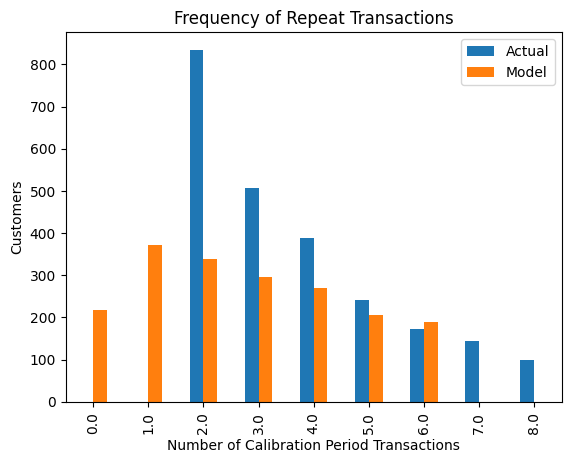

In [43]:
################################################################
# Tahmin Sonuçlarının Değerlendirilmesi
################################################################

plot_period_transactions(bgf)
plt.show()

#### 3.2. Establishing the Gamma-Gamma Model(GAMMA-GAMMA Modelinin Kurulması)

In [44]:
# model nesnesi oluşturuyoruz
ggf = GammaGammaFitter(penalizer_coef=0.01)

In [45]:
# modelin kurulması için frequency ve monetary değerleri lazım, bunları parametre olarak veririz
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2845 subjects, p: 3.79, q: 0.34, v: 3.73>

In [46]:
# ilk 10 müşteri için average profit hesaplanır
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).head(10)

Customer ID
12347.0000    631.9123
12348.0000    463.7460
12352.0000    224.8868
12356.0000    995.9989
12358.0000    631.9022
12359.0000   1435.0385
12360.0000    933.7905
12362.0000    532.2318
12363.0000    304.2643
12364.0000    344.1370
dtype: float64

In [47]:
# azalan sıraya göre sıralar, average profit'i en yüksek olan 10 müşteriyi verdi
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).sort_values(ascending=False).head(10)

Customer ID
12415.0000   5772.1782
12590.0000   5029.4196
12435.0000   4288.9440
12409.0000   3918.8128
14088.0000   3917.1297
18102.0000   3870.9969
12753.0000   3678.5783
14646.0000   3654.8148
15749.0000   3216.0523
14096.0000   3196.4361
dtype: float64

In [48]:
# dataframe'e ekler 
cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])

In [49]:
cltv_df.sort_values("expected_average_profit", ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit
Customer ID,,,,,,,,
12415.0000,44.7143,48.2857,21,5724.3026,0.3796,1.5139,4.5080,5772.1782
12590.0000,0.0000,30.2857,2,4591.1725,0.0115,0.0460,0.1363,5029.4196
12435.0000,26.8571,38.2857,2,3914.9450,0.0763,0.3041,0.9035,4288.9440
12409.0000,14.7143,26.1429,3,3690.8900,0.1174,0.4674,1.3854,3918.8128
14088.0000,44.5714,46.1429,13,3864.5546,0.2603,1.0379,3.0896,3917.1297
18102.0000,52.2857,52.5714,60,3859.7391,0.9685,3.8636,11.5112,3870.9969
12753.0000,48.4286,51.8571,6,3571.5650,0.1261,0.5028,1.4973,3678.5783
14646.0000,50.4286,50.7143,73,3646.0757,1.2064,4.8119,14.3340,3654.8148
15749.0000,13.8571,47.5714,3,3028.7800,0.0280,0.1116,0.3320,3216.0523


### 4. Calculation of CLTV with BG-NBD and GG Model(BG-NBD ve GG modeli ile CLTV'nin hesaplanması)

In [50]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,  # 3 aylık
                                   freq="W",  # T'nin frekans bilgisi, haftalık
                                   discount_rate=0.01) # indirim oranı

In [51]:
cltv.head()

Customer ID
12347.0000   1128.4477
12348.0000    538.8089
12352.0000    517.5000
12356.0000   1083.0903
12358.0000    966.6727
Name: clv, dtype: float64

In [52]:
# yukarıdaki çıktıda index olarak customer ID'yi almış bunu düzeltmek için "reset_index" fonk. kullanılır
cltv = cltv.reset_index()

In [53]:
cltv.head()

,Customer ID,clv
0,12347.0000,1128.4477
1,12348.0000,538.8089
2,12352.0000,517.5000
3,12356.0000,1083.0903
4,12358.0000,966.6727


In [54]:
# daha önce oluşturduğumuz cltv_df ile cltv dataframe'lerini birleştirir
# cltv değerine göre büyükten küçüğe sıralar 
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv
1122,14646.0000,50.4286,50.7143,73,3646.0757,1.2064,4.8119,14.3340,3654.8148,55741.0845
2761,18102.0000,52.2857,52.5714,60,3859.7391,0.9685,3.8636,11.5112,3870.9969,47412.5801
843,14096.0000,13.8571,14.5714,17,3163.5882,0.7287,2.8955,8.5526,3196.4361,29061.6614
36,12415.0000,44.7143,48.2857,21,5724.3026,0.3796,1.5139,4.5080,5772.1782,27685.1000
1257,14911.0000,53.1429,53.4286,201,691.7101,3.1264,12.4722,37.1641,692.3264,27377.4115
2458,17450.0000,51.2857,52.5714,46,2863.2749,0.7474,2.9815,8.8830,2874.1987,27166.0643
874,14156.0000,51.5714,53.1429,55,2104.0267,0.8775,3.5005,10.4298,2110.7542,23424.4032
2487,17511.0000,52.8571,53.4286,31,2933.9431,0.5088,2.0298,6.0476,2950.5801,18986.6123
2075,16684.0000,50.4286,51.2857,28,2209.9691,0.4781,1.9068,5.6801,2223.8850,13440.4131
650,13694.0000,52.7143,53.4286,50,1275.7005,0.8008,3.1946,9.5186,1280.2183,12966.1347


- 3 aylık müşteri yaşam boyu değeri(cltv) tahminini gerçekleştirdik.

### 5. Creating the Customer Segment(CLTV'ye Göre Segmentlerin Oluşturulması)

In [55]:
# qcut fonk. clv değerine göre küçükten büyüğe sıralar ve 4' böler
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

In [56]:
cltv_final.sort_values(by="clv", ascending=False).head(50)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_purc_3_month,expected_average_profit,clv,segment
1122,14646.0000,50.4286,50.7143,73,3646.0757,1.2064,4.8119,14.3340,3654.8148,55741.0845,A
2761,18102.0000,52.2857,52.5714,60,3859.7391,0.9685,3.8636,11.5112,3870.9969,47412.5801,A
843,14096.0000,13.8571,14.5714,17,3163.5882,0.7287,2.8955,8.5526,3196.4361,29061.6614,A
36,12415.0000,44.7143,48.2857,21,5724.3026,0.3796,1.5139,4.5080,5772.1782,27685.1000,A
1257,14911.0000,53.1429,53.4286,201,691.7101,3.1264,12.4722,37.1641,692.3264,27377.4115,A
2458,17450.0000,51.2857,52.5714,46,2863.2749,0.7474,2.9815,8.8830,2874.1987,27166.0643,A
874,14156.0000,51.5714,53.1429,55,2104.0267,0.8775,3.5005,10.4298,2110.7542,23424.4032,A
2487,17511.0000,52.8571,53.4286,31,2933.9431,0.5088,2.0298,6.0476,2950.5801,18986.6123,A
2075,16684.0000,50.4286,51.2857,28,2209.9691,0.4781,1.9068,5.6801,2223.8850,13440.4131,A
650,13694.0000,52.7143,53.4286,50,1275.7005,0.8008,3.1946,9.5186,1280.2183,12966.1347,A


In [57]:
cltv_final.groupby("segment").agg(
    {"count", "mean", "sum"})

Customer ID                     recency                        T               frequency                  monetary                expected_purc_1_week              expected_purc_1_month              expected_purc_3_month              expected_average_profit                         clv                
                  sum count       mean        sum count    mean        sum count    mean       sum count    mean         sum count     mean                  sum count   mean                   sum count   mean                   sum count   mean                     sum count     mean          sum count      mean
segment                                                                                                                                                                                                                                                                                                                
D       11077635.0000   712 15558.4761 15716.5714   712 22.0738 28811.0000   712 40.4649      2182   712  3.0646 130981.7123   712 183.9631              50.5898   712 0.0711              201.4774   712 0.2830              598.0905   712 0.8400             141999.6650   712 199.4377  102027.4901   712  143.2970
C       10885150.0000   711 15309.6343 21806.1429   711 30.6697 27097.0000   711 38.1111      2912   711  4.0956 193174.9847   711 271.6948              85.7309   711 0.1206              341.3936   711 0.4802             1013.2176   711 1.4251             206179.7461   711 289.9856  270743.0065   711  380.7919
B       10915854.0000   711 15352.8186 20985.0000   711 29.5148 24751.1429   711 34.8117      3869   711  5.4416 265517.6312   711 373.4425             115.5066   711 0.1625              459.6926   711 0.6465             1362.6595   711 1.9165             280058.9431   711 393.8944  489356.3925   711  688.2650
A       10627572.0000   711 14947.3586 22333.1429   711 31.4109 24518.1429   711 34.4840      8076   711 11.3586 469159.4581   711 659.8586             194.4993   711 0.2736              774.3298   711 1.0891             2297.1448   711 3.2309             487674.7239   711 685.8998 1580097.9284   711 2222.3600

### 6. Functionalization(Çalışmanın Fonksiyonlaştırılması)

In [58]:
# Önceki bölümlerde teker teker yapılan tüm işlemleri burda bir fonksiyon altında birleştirdik

def create_cltv_p(dataframe, month=3):
    # 1. Veri Ön İşleme
    dataframe.dropna(inplace=True)
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]
    dataframe = dataframe[dataframe["Quantity"] > 0]
    dataframe = dataframe[dataframe["Price"] > 0]
    replace_with_thresholds(dataframe, "Quantity")
    replace_with_thresholds(dataframe, "Price")
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    today_date = dt.datetime(2011, 12, 11)

    cltv_df = dataframe.groupby('Customer ID').agg(
        {'InvoiceDate': [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days,
                         lambda InvoiceDate: (today_date - InvoiceDate.min()).days],
         'Invoice': lambda Invoice: Invoice.nunique(),
         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

    cltv_df.columns = cltv_df.columns.droplevel(0)
    cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']
    cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]
    cltv_df = cltv_df[(cltv_df['frequency'] > 1)]
    cltv_df["recency"] = cltv_df["recency"] / 7
    cltv_df["T"] = cltv_df["T"] / 7

    # 2. BG-NBD Modelinin Kurulması
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T'])

    cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                                  cltv_df['frequency'],
                                                  cltv_df['recency'],
                                                  cltv_df['T'])

    cltv_df["expected_purc_1_month"] = bgf.predict(4,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

    cltv_df["expected_purc_3_month"] = bgf.predict(12,
                                                   cltv_df['frequency'],
                                                   cltv_df['recency'],
                                                   cltv_df['T'])

    # 3. GAMMA-GAMMA Modelinin Kurulması
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(cltv_df['frequency'], cltv_df['monetary'])
    cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                                 cltv_df['monetary'])

    # 4. BG-NBD ve GG modeli ile CLTV'nin hesaplanması.
    cltv = ggf.customer_lifetime_value(bgf,
                                       cltv_df['frequency'],
                                       cltv_df['recency'],
                                       cltv_df['T'],
                                       cltv_df['monetary'],
                                       time=month,  # 3 aylık
                                       freq="W",  # T'nin frekans bilgisi.
                                       discount_rate=0.01)

    cltv = cltv.reset_index()
    cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
    cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

    return cltv_final

In [59]:
df = df_.copy()

In [60]:
cltv_final2 = create_cltv_p(df)

In [61]:
cltv_final2.to_csv("cltv_prediction.csv")